https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\eolearn\io\processing_api.py:176: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ProcApiType("bool_mask", 'DN', 'UINT8', np.bool, FeatureType.MASK): [


C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimension of the area is 2496630 x 2139124 m2


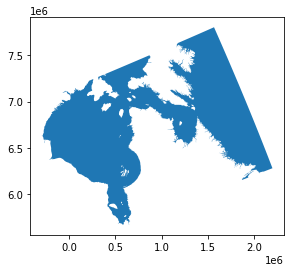

In [2]:
# Load geojson file
ice_gdf = gpd.read_file('data/cis_SGRDRHB_20200525T1800Z_pl_a.shp')#load shape file inclusing sea ice concentration data
ice_gdf = ice_gdf.to_crs('EPSG:32617')

region = ice_gdf.dropna()#remove polygons where there is not data (corresponds to land)
region = region.geometry.unary_union#get the untion of all the water area
region = gpd.GeoDataFrame(geometry=[region], crs=ice_gdf.crs)

# region = region.buffer(500)

# Get the country's shape in polygon format
region_shape = region.geometry.values[-1]

# Plot country
region.plot()

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(region_shape.bounds[2] - region_shape.bounds[0],
                                                             region_shape.bounds[3] - region_shape.bounds[1]))

In [3]:
from sentinelhub import BBoxSplitter
# Create the splitter to obtain a list of bboxes
bbox_splitter = BBoxSplitter([region_shape], region.crs, (50, 50))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())
for n, info in enumerate(info_list):
    info['index']=n

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=region.crs,
                           geometry=geometry)

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


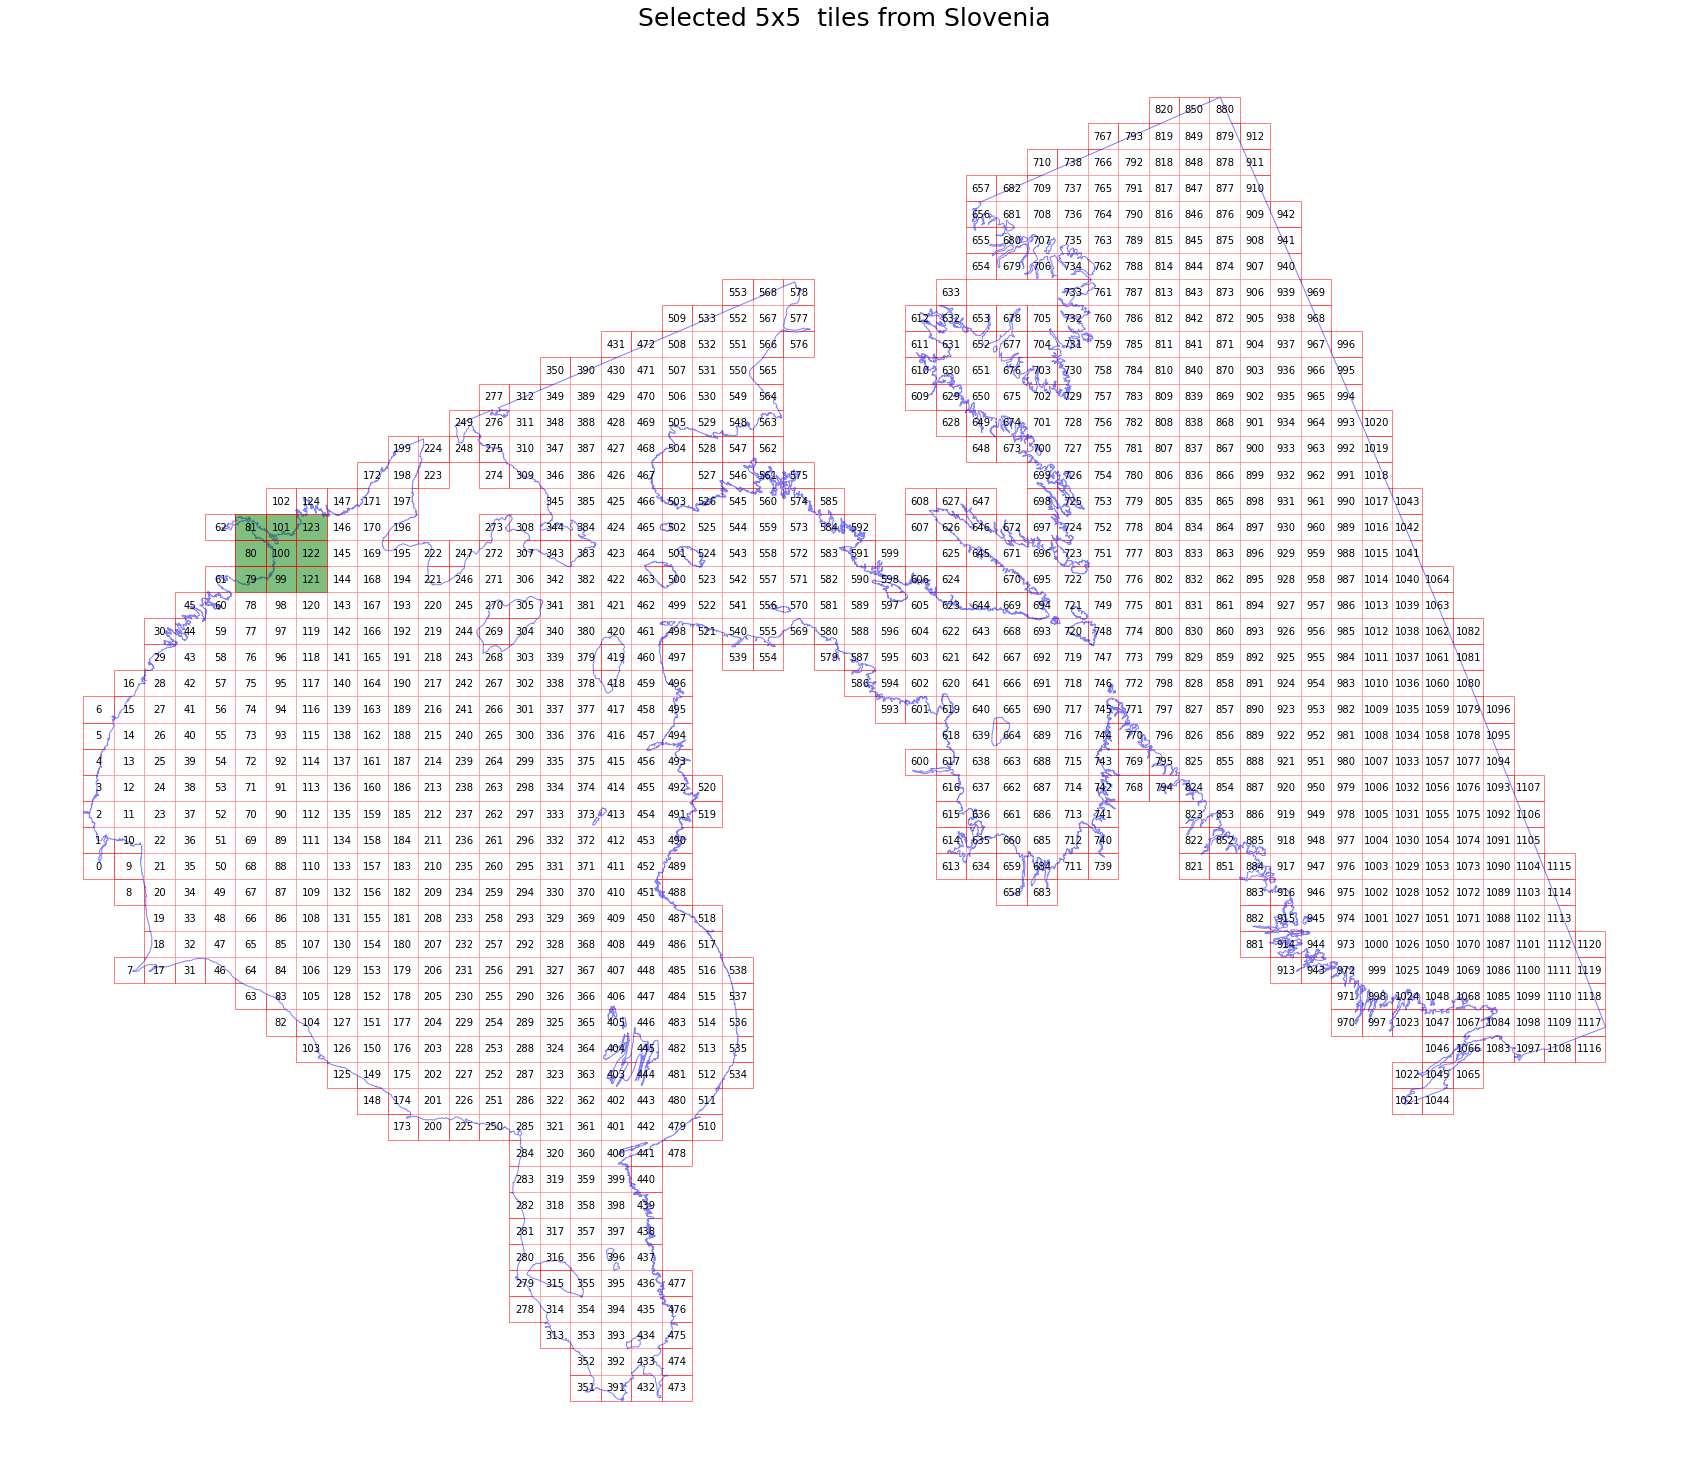

In [4]:
# select a 5x5 area (id of center patch)
ID = 100

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 5x5
if len(patchIDs) != 3*3:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

# save to shapefile
shapefile_name = './grid_slovenia_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
region.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from Slovenia', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [10]:
band_names = ['B03', 'B04', 'B08']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=100,
    maxcc=0.1,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
)

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


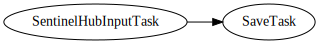

In [11]:
workflow = LinearWorkflow(
    add_data,
    save,)
# Let's visualize it
workflow.dependency_graph()

In [12]:
%%time

# Execute the workflow
time_interval = ['2019-05-01', '2019-6-01'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    print(execution_args[0])

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run()

executor.make_report()

{<eolearn.io.processing_api.SentinelHubInputTask object at 0x000001C5ACDFED48>: {'bbox': BBox(((-47701.2632706202, 7077121.472556221), (2231.334016373963, 7119903.956797445)), crs=CRS('32617')), 'time_interval': ['2019-05-01', '2019-6-01']}, <eolearn.core.core_tasks.SaveTask object at 0x000001C5B22F3C08>: {'eopatch_folder': 'eopatch_0'}}
{<eolearn.io.processing_api.SentinelHubInputTask object at 0x000001C5ACDFED48>: {'bbox': BBox(((-47701.2632706202, 7077121.472556221), (2231.334016373963, 7119903.956797445)), crs=CRS('32617')), 'time_interval': ['2019-05-01', '2019-6-01']}, <eolearn.core.core_tasks.SaveTask object at 0x000001C5B22F3C08>: {'eopatch_folder': 'eopatch_0'}}
{<eolearn.io.processing_api.SentinelHubInputTask object at 0x000001C5ACDFED48>: {'bbox': BBox(((-47701.2632706202, 7077121.472556221), (2231.334016373963, 7119903.956797445)), crs=CRS('32617')), 'time_interval': ['2019-05-01', '2019-6-01']}, <eolearn.core.core_tasks.SaveTask object at 0x000001C5B22F3C08>: {'eopatch_fol

  0%|          | 0/9 [00:00<?, ?it/s]

Wall time: 43.3 s


In [13]:
EOPatch.load('./eopatches/eopatch_0/')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(3, 428, 499, 3), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 499
    size_y: 428
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-05-01T00:00:00', '2019-06-01T23:59:59')
  }
  bbox: BBox(((-47701.2632706202, 7077121.472556221), (2231.334016373963, 7119903.956797445)), crs=CRS('32617'))
  timestamp: [datetime.datetime(2019, 5, 1, 17, 36, 17), ..., datetime.datetime(2019, 5, 19, 17, 46, 6)], length=3
)

2019-05-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

2019-05-07 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

2019-05-14 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

2019-05-21 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

2019-05-28 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

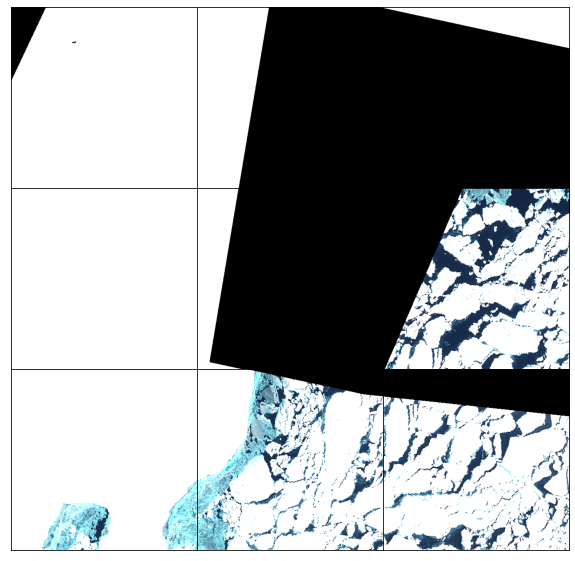

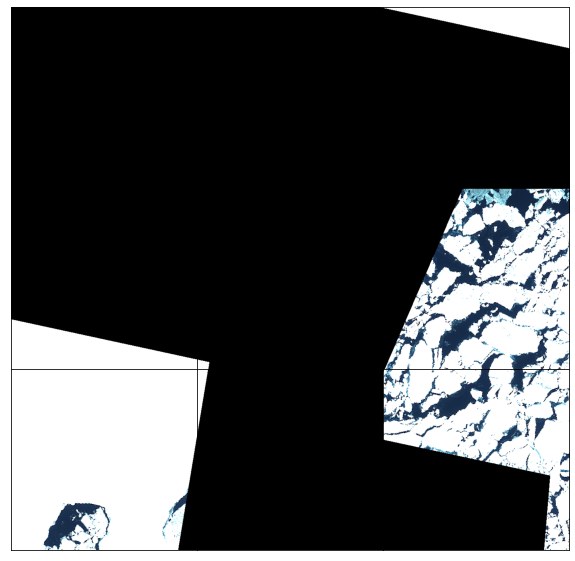

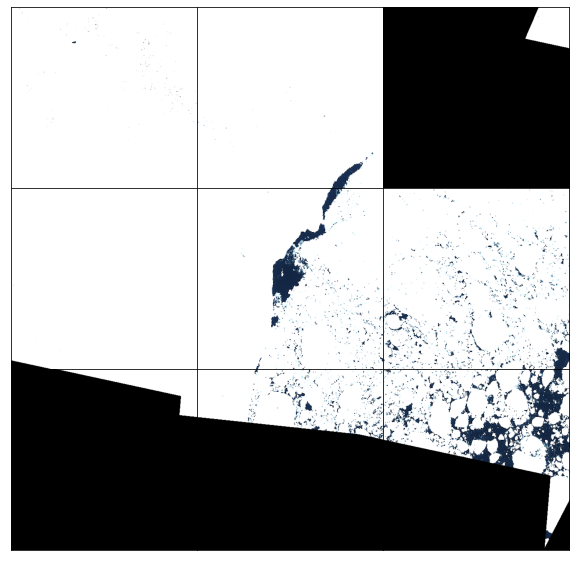

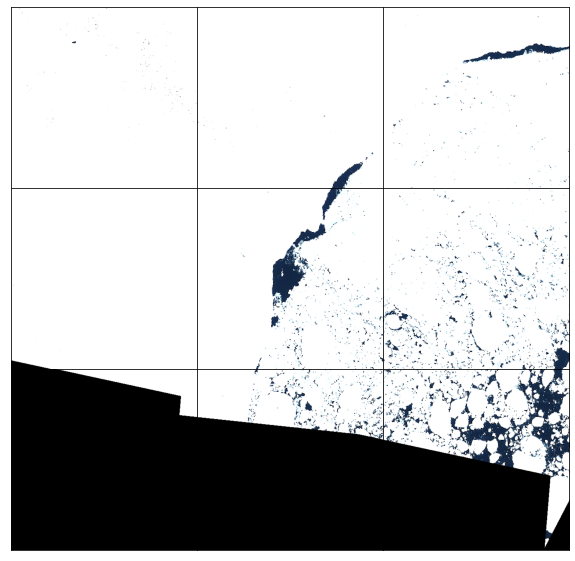

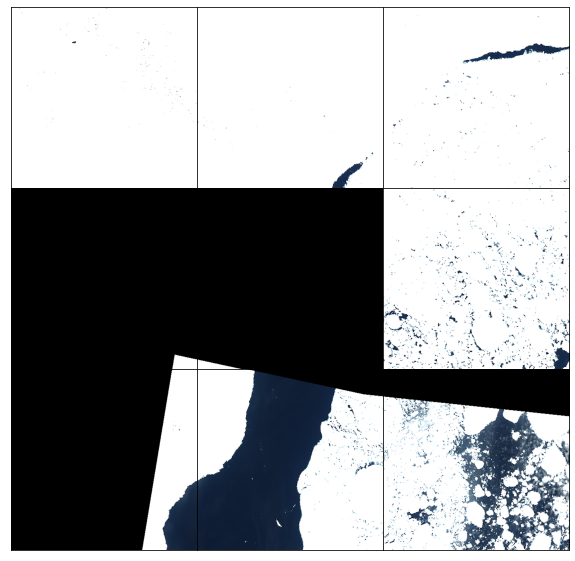

In [14]:
# Draw the RGB image
path_out = './eopatches'

for n in [1, 7, 14, 21, 28]:
    date = datetime.datetime(2019,5,n)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

    print(date)
    for i in tqdm(range(len(patchIDs))):
        eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
        ax = axs[i//3][i%3]
        dates = np.array(eopatch.timestamp)
        closest_date_id = np.argsort(abs(date-dates))[0]
        ax.imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")
        del eopatch

    fig.subplots_adjust(wspace=0, hspace=0)